In [2]:
%pip install plotly

import pandas as pd
import numpy as np
import plotly.express as px
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 27.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [40]:
supermarket = pd.read_csv('/Users/raneem/Downloads/supermarket_pred/sales.csv')

/var/folders/ts/c0z20d1s1rq1pd4h0py597pw0000gn/T/ipykernel_11848/4060225151.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  supermarket = pd.read_csv('/Users/raneem/Downloads/supermarket_pred/sales.csv')


 ## 1 - Explore The Dataset

In [41]:
supermarket.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,260670,166,2,2013-01-01,0,0,0,a,1,0
1,366950,278,2,2013-01-01,0,0,0,a,1,0
2,179596,519,2,2013-01-01,0,0,0,a,1,0
3,216955,234,2,2013-01-01,0,0,0,a,1,0
4,201196,270,2,2013-01-01,0,0,0,a,1,0


In [42]:
supermarket.dtypes

Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object

In [43]:
supermarket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592561 entries, 0 to 592560
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           592561 non-null  int64 
 1   store_ID             592561 non-null  int64 
 2   day_of_week          592561 non-null  int64 
 3   date                 592561 non-null  object
 4   nb_customers_on_day  592561 non-null  int64 
 5   open                 592561 non-null  int64 
 6   promotion            592561 non-null  int64 
 7   state_holiday        592561 non-null  object
 8   school_holiday       592561 non-null  int64 
 9   sales                592561 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 45.2+ MB


In [44]:
supermarket.shape

(592561, 10)

In [45]:
supermarket.describe()

,Unnamed: 0,store_ID,day_of_week,nb_customers_on_day,open,promotion,school_holiday,sales
count,592561.000000,592561.000000,592561.000000,592561.000000,592561.000000,592561.000000,592561.000000,592561.000000
mean,356039.480762,558.463546,4.002315,634.848002,0.831509,0.379419,0.181418,5744.577431
std,205596.545847,321.957991,1.995855,465.330476,0.374302,0.485243,0.385364,3832.896126
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,177871.000000,280.000000,2.000000,404.000000,1.000000,0.000000,0.000000,3703.000000
50%,356159.000000,558.000000,4.000000,609.000000,1.000000,0.000000,0.000000,5702.000000
75%,534138.000000,837.000000,6.000000,839.000000,1.000000,1.000000,0.000000,7808.000000
max,712044.000000,1115.000000,7.000000,5494.000000,1.000000,1.000000,1.000000,38037.000000


In [46]:
supermarket['state_holiday'].value_counts()

state_holiday
0    572395
a     11363
b      3167
c      2899
0      2737
Name: count, dtype: int64

In [47]:
for val in supermarket['state_holiday'].unique():
    print(f"Value: {val}, Type: {type(val)}") 
# The 0 is counted as two types : str and int, so we will convert all to strings then encoding them.

Value: a, Type: <class 'str'>
Value: 0, Type: <class 'str'>
Value: b, Type: <class 'str'>
Value: c, Type: <class 'str'>
Value: 0, Type: <class 'int'>


In [48]:
supermarket['state_holiday'] = supermarket['state_holiday'].astype(str)
supermarket['state_holiday'].value_counts()

state_holiday
0    575132
a     11363
b      3167
c      2899
Name: count, dtype: int64

In [49]:
# Now we will encode with LabelEncoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

supermarket['state_holiday'] = encoder.fit_transform(supermarket['state_holiday'])
supermarket['state_holiday'].value_counts()

state_holiday
0    575132
1     11363
2      3167
3      2899
Name: count, dtype: int64

In [50]:
numerical = supermarket._get_numeric_data()

categorical = [i for i in supermarket if i not in numerical]

#for num in numerical:
print("Numerical:", list(supermarket._get_numeric_data().keys()))
print("\n")
#for col in categorical:
print("Categorical:", categorical)

Numerical: ['Unnamed: 0', 'store_ID', 'day_of_week', 'nb_customers_on_day', 'open', 'promotion', 'state_holiday', 'school_holiday', 'sales']


Categorical: ['date']


In [51]:
# Convert 'date' column to datetime type
supermarket['date'] = pd.to_datetime(supermarket['date'])

# Verify the conversion
print(supermarket.dtypes)

Unnamed: 0                      int64
store_ID                        int64
day_of_week                     int64
date                   datetime64[ns]
nb_customers_on_day             int64
open                            int64
promotion                       int64
state_holiday                   int64
school_holiday                  int64
sales                           int64
dtype: object


In [52]:
# Create a date range for the next 4 months
'''this line of code generates a sequence of 120 daily dates starting
 from the day after the latest date in the supermarket['date'] column.
 The result is stored in the future_dates variable.'''
 
future_dates = pd.date_range(start=supermarket['date'].max() + pd.Timedelta(days=1), periods=120, freq='D')


In [54]:
# Extract year, month, and day from the 'date' column
supermarket['year'] = supermarket['date'].dt.year
supermarket['month'] = supermarket['date'].dt.month
supermarket['day'] = supermarket['date'].dt.day

# Drop the 'date' column as it is no longer needed
supermarket.drop('date', inplace=True, axis=1)

In [55]:
# Drop the 'Unnamed: 0' column from the supermarket dataframe
supermarket.drop('Unnamed: 0', axis=1, inplace=True)

In [56]:
supermarket.head()

,store_ID,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,year,month,day
0,166,2,0,0,0,1,1,0,2013,1,1
1,278,2,0,0,0,1,1,0,2013,1,1
2,519,2,0,0,0,1,1,0,2013,1,1
3,234,2,0,0,0,1,1,0,2013,1,1
4,270,2,0,0,0,1,1,0,2013,1,1


In [57]:
# Calculate the correlations between each of these variables and the outcome variable 'sales'
correlation = supermarket.corr()

# Display the correlation of each variable with 'sales'
correlation_with_sales = correlation['sales'].sort_values(ascending=False)
print(correlation_with_sales)

sales                  1.000000
nb_customers_on_day    0.897044
open                   0.674661
promotion              0.451301
school_holiday         0.077069
month                  0.055609
year                   0.015881
store_ID               0.006163
day                   -0.017814
state_holiday         -0.223132
day_of_week           -0.458726
Name: sales, dtype: float64


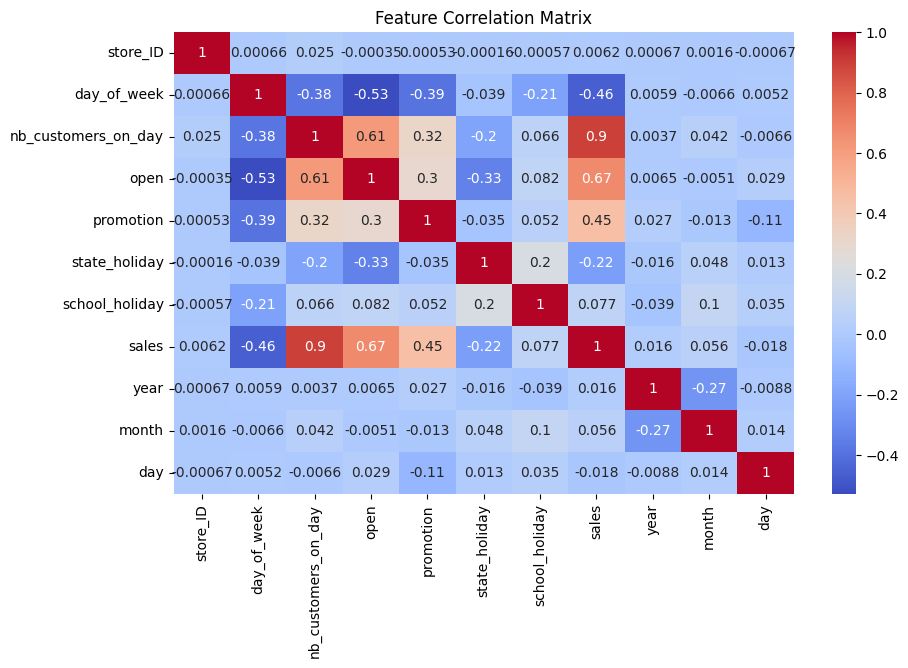

In [60]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [58]:
# The most important variable to determine sales is :
# nb_customers_on_day    0.897044
# open                   0.674661
# promotion              0.451301

In [ ]:
# We are using the simple linear regression

# My outcome variable is salse since we are
# trying to predict the  predict the sales for the upcoming 4 months for every day

In [ ]:
# Define the model
model = LinearRegression()

# Define the features (X) and the target (y)
X = supermarket[['nb_customers_on_day', 'open', 'promotion', 'state_holiday', 'school_holiday', 'year', 'month', 'day']]
y = supermarket['sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Calculate R^2 score for the training set
train_r2 = r2_score(y_train, y_train_pred)
print(f"Training R^2 score: {train_r2}")

# Predict on the testing set
y_test_pred = model.predict(X_test)

# Calculate R^2 score for the testing set
test_r2 = r2_score(y_test, y_test_pred)
print(f"Testing R^2 score: {test_r2}")